##### Import & Seed:

In [ ]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from scipy.integrate import odeint
from scipy.linalg import hankel
from pyDOE import lhs
from scipy.io import savemat
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split

from utils_EKFSINDy import add_noise_with_snr, jacobian_A, jacobian_H

from sklearn.linear_model import Lasso
#from pysindy.optimizers import SR3

from Data import SINDy_data
from Data import data
from Data import equations

np.random.seed(999)

In [ ]:
# Sparse optimization methods:

# Model 0: Sequential Thresholded Least Squares with low threshold -> overfitting
# L'ottimizzatore STLSQ (Sequential Thresholded Least Squares) applica una soglia ai coefficienti ottenuti tramite il metodo dei minimi quadrati
# per ottenere un modello sparso. Dopo aver ottenuto una soluzione iniziale, i coefficienti più piccoli (al di sotto della soglia specificata) 
# vengono impostati a zero, e il processo di stima viene iterato fino a ottenere una convergenza.

# Model 1: Sequential Thresholded Least Squares 
# RMK. conoscendo il risultato corretto, sappiamo che il coefficiente mino che il modello deve individuare è 0.1 -> threshold ~= 0.1

# Model 2: Lasso
# RMK. L'ottimizzatore Lasso (Least Absolute Shrinkage and Selection Operator) introduce una penalizzazione L1 sui coefficienti nel processo 
# di regressione. Questo metodo non solo impone sparseness, ma anche seleziona automaticamente le caratteristiche più rilevanti. 
# La penalizzazione L1 tende a ridurre a zero i coefficienti dei termini meno importanti, eliminandoli dal modello.


# Other methods: 

# Orthogonal Matching Pursuit
# from sklearn.linear_model import OrthogonalMatchingPursuit
# model_omp = ps.SINDy(feature_names=feature_names, 
#                      feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), 
#                      optimizer=OrthogonalMatchingPursuit())
# RMK. Seleziona iterativamente i coefficienti che spiegano la maggior parte della variabilità residua nel modello.

#Sequentially Thresholded Ridge Regression
# model_stridge = ps.SINDy(feature_names=feature_names, 
#                          feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), 
#                          optimizer=ps.STLSQ(threshold=0.08, alpha=1.0))
# Simile a STLSQ, ma utilizza Ridge Regression come base per il processo iterativo di soglia.


# Just in case: automatic definition of 𝝀 parameter for Lasso: aggiungere codice per idividuare the largest 𝝀 value such that the MSE is within one standard error from its minimum (to the right)



##### $\rho \simeq 0.9$

In [3]:
# Select ODE & settings:
ode_name = 'SelkovODE_rho_09'
ode_param=None
freq = 10
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 2
ode = equations.get_ode(ode_name, ode_param)

In [4]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 150, 2) (50, 150, 2) (50, 150)
['x1', 'x2', 'k']


Threshold:  0.0001 , RMSE:  0.03460717372263146
Threshold:  0.001 , RMSE:  0.03460717372263146
Threshold:  0.01 , RMSE:  0.03460717372263146
Threshold:  0.05 , RMSE:  0.028305336637004058
Threshold:  0.075 , RMSE:  0.04345236920590999
Threshold:  0.1 , RMSE:  3.2441828211731227
Threshold:  0.2 , RMSE:  3.433250951868594
Threshold:  0.4 , RMSE:  3.433250951868594
Threshold:  0.6 , RMSE:  3.433250951868594


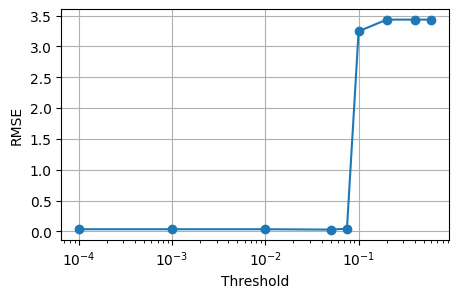

In [5]:
# model selection:
thresholds = np.array([0.0001, 0.001, 0.01, 0.05, 0.075, 0.1, 0.2, 0.4, 0.6])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.1, 0.1, 0.95], [0, 0, 0.85])
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)   

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds: 0.075

In [11]:
# best models:
best_threshold_1 = 0.075
model_09_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_1))
model_09_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_09_1.print()

(x1)' = 0.551 k + 0.727 k^2 + -0.842 x1 x2^2 + -0.314 x1 x2 k + -0.128 x2^2 k + 0.303 x2 k^2 + -0.401 k^3
(x2)' = 0.102 x1 + -1.202 x2 + 0.480 x2 k + 0.984 x1 x2^2 + -0.266 x2 k^2


Best Model RMSE:  0.042695272633277874


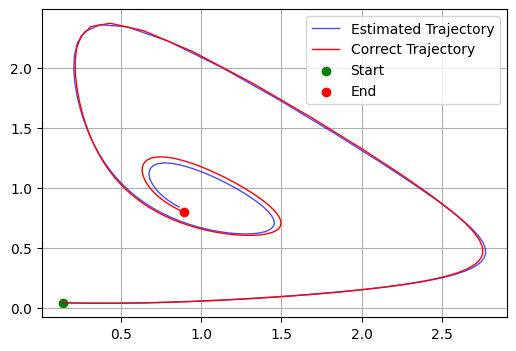

In [12]:
# evaluation:
n_sample = 25
rmse_09_1 = SINDy_data.evaluate_RMSE(model_09_1, ode, freq, n_sample, [0.1, 0.1, 0.95], [0, 0, 0.85])
print('Best Model RMSE: ', rmse_09_1)
n_sample = 1
SINDy_data.evaluate_traj(model_09_1, ode, freq, n_sample, [0.05, 0.05, 0.9], [0.05, 0.05, 0.9], dim_x)


rho=0.6, RMSE:  0.10361403806586654
rho=0.4, RMSE:  0.15099109378849906


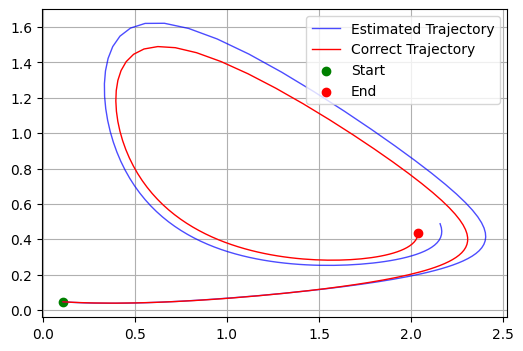

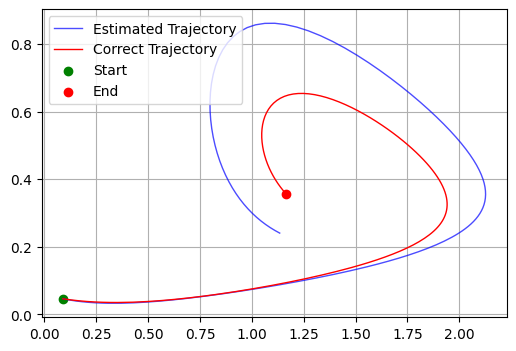

In [13]:
# Best Model, test on different parameter values:
init_point = [0.05, 0.05, 0.6]
rmse_0 = SINDy_data.evaluate_RMSE(model_09_1, ode, freq, n_sample, init_point, init_point)
print('rho=0.6, RMSE: ', rmse_0)
SINDy_data.evaluate_traj(model_09_1, ode, freq, n_sample, init_point, init_point, dim_x)

init_point = [0.05, 0.05, 0.4]
rmse_0 = SINDy_data.evaluate_RMSE(model_09_1, ode, freq, n_sample, init_point, init_point)
print('rho=0.4, RMSE: ', rmse_0)
SINDy_data.evaluate_traj(model_09_1, ode, freq, n_sample, init_point, init_point, dim_x)


##### $\rho \simeq 0.6$

In [14]:
# Select ODE & settings:
ode_name = 'SelkovODE_rho_06'
ode_param=None
freq = 10
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 2
ode = equations.get_ode(ode_name, ode_param)

In [15]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 150, 2) (50, 150, 2) (50, 150)
['x1', 'x2', 'k']


Threshold:  0.0001 , RMSE:  0.00228257097194673
Threshold:  0.001 , RMSE:  0.00228257097194673
Threshold:  0.01 , RMSE:  0.002352571440162521
Threshold:  0.05 , RMSE:  0.010756096546684068
Threshold:  0.075 , RMSE:  0.09477035110908166
Threshold:  0.1 , RMSE:  1.7676211132749444
Threshold:  0.2 , RMSE:  1.7676211132749444
Threshold:  0.4 , RMSE:  1.7710225138341809
Threshold:  0.6 , RMSE:  1.7710225138341809


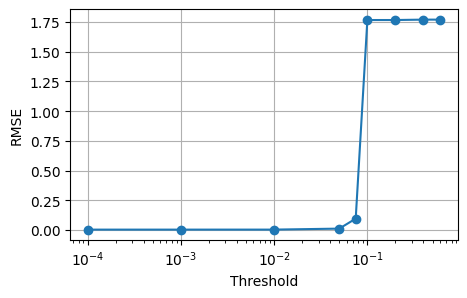

In [16]:
# model selection:
thresholds = np.array([0.0001, 0.001, 0.01, 0.05, 0.075, 0.1, 0.2, 0.4, 0.6])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.1, 0.1, 0.65], [0, 0, 0.55])
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)   

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds: 0.05

In [19]:
# best models:
best_threshold = 0.05
model_06 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold))
model_06.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_06.print()

#model_2 = ps.SINDy(feature_names = feature_names, feature_library= ps.PolynomialLibrary(degree = 3, include_bias=False), optimizer=Lasso(alpha=0.01))

(x1)' = 0.362 k + 1.388 k^2 + -1.000 x1 x2^2 + -0.269 x1 k^2 + -0.561 k^3
(x2)' = 0.100 x1 + -1.000 x2 + 1.000 x1 x2^2


Best Model RMSE:  0.009957278991851224


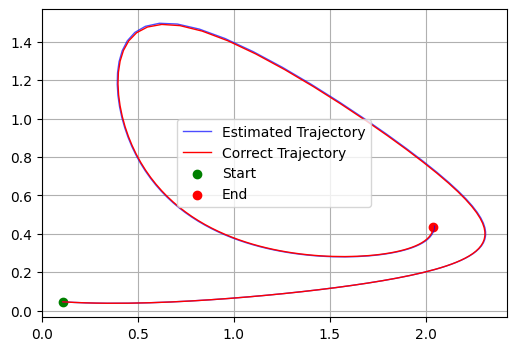

In [20]:
# evaluation:
n_sample = 25
rmse_06 = SINDy_data.evaluate_RMSE(model_06, ode, freq, n_sample, [0.1, 0.1, 0.65], [0, 0, 0.55])
print('Best Model RMSE: ', rmse_06)
n_sample = 1
SINDy_data.evaluate_traj(model_06, ode, freq, n_sample, [0.05, 0.05, 0.6], [0.05, 0.05, 0.6], dim_x)


rho=0.6, RMSE:  0.18127090775177077
rho=0.4, RMSE:  0.12414384313791842


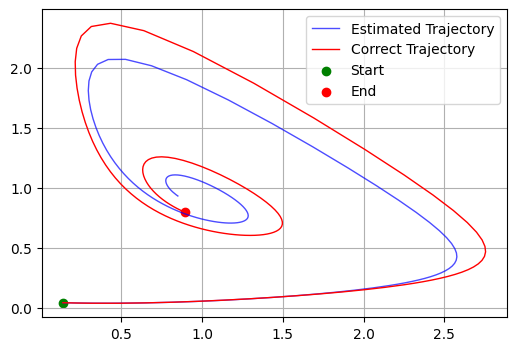

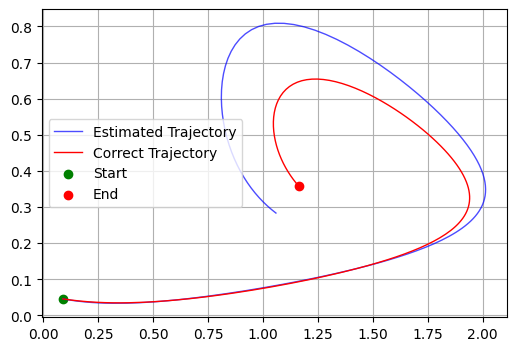

In [21]:
# Best Model, test on different parameter values:
init_point = [0.05, 0.05, 0.9]
rmse_0 = SINDy_data.evaluate_RMSE(model_06, ode, freq, n_sample, init_point, init_point)
print('rho=0.6, RMSE: ', rmse_0)
SINDy_data.evaluate_traj(model_06, ode, freq, n_sample, init_point, init_point, dim_x)

init_point = [0.05, 0.05, 0.4]
rmse_0 = SINDy_data.evaluate_RMSE(model_06, ode, freq, n_sample, init_point, init_point)
print('rho=0.4, RMSE: ', rmse_0)
SINDy_data.evaluate_traj(model_06, ode, freq, n_sample, init_point, init_point, dim_x)


##### $\rho \simeq 0.4$

In [2]:
# Select ODE & settings:
ode_name = 'SelkovODE_rho_04'
ode_param=None
freq = 10
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 2
ode = equations.get_ode(ode_name, ode_param)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 150, 2) (50, 150, 2) (50, 150)
['x1', 'x2', 'k']


Threshold:  0.0001 , RMSE:  0.0004636423164999454
Threshold:  0.001 , RMSE:  0.00042782801681907933
Threshold:  0.01 , RMSE:  0.0008054051224204866
Threshold:  0.05 , RMSE:  0.0003309213566074738
Threshold:  0.1 , RMSE:  0.8114438016461399
Threshold:  0.2 , RMSE:  0.8689782859384152


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(


Threshold:  0.4 , RMSE:  0.8530658267055775


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.6) and eliminated all coefficients
  warnings.warn(


Threshold:  0.6 , RMSE:  0.8530658267055775


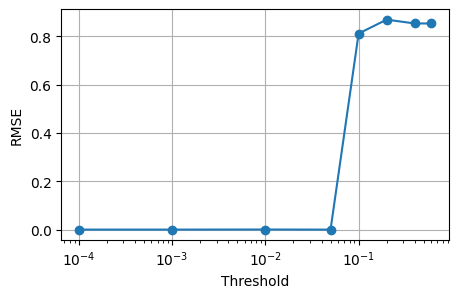

In [4]:
# model selection:
thresholds = np.array([0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.1, 0.1, 0.45], [0, 0, 0.35])
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)   

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds: 0.05
# RMK. 0.075 crashes

In [5]:
# best models:
best_threshold = 0.05
model_04 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold))
model_04.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_04.print()

#model_2 = ps.SINDy(feature_names = feature_names, feature_library= ps.PolynomialLibrary(degree = 3, include_bias=False), optimizer=Lasso(alpha=0.01))

(x1)' = -0.100 x1 + 1.000 k + -1.000 x1 x2^2
(x2)' = 0.099 x1 + -0.984 x2 + -0.046 x2^2 + 1.004 x1 x2^2 + 0.030 x2^3


Best Model RMSE:  0.00032135754908188736


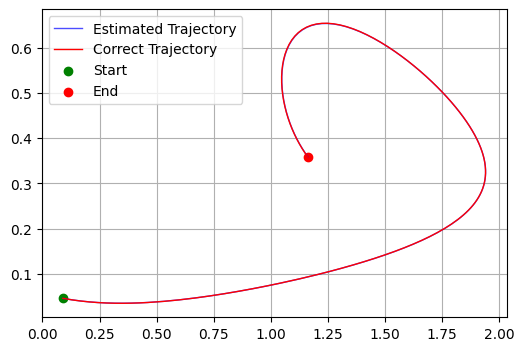

In [6]:
# evaluation:
n_sample = 25
rmse_04 = SINDy_data.evaluate_RMSE(model_04, ode, freq, n_sample, [0.1, 0.1, 0.45], [0, 0, 0.35])
print('Best Model RMSE: ', rmse_04)
n_sample = 1
SINDy_data.evaluate_traj(model_04, ode, freq, n_sample, [0.05, 0.05, 0.4], [0.05, 0.05, 0.4], dim_x)

rho=0.9, RMSE:  0.03063074063637773
rho=0.6, RMSE:  0.006407189047582955


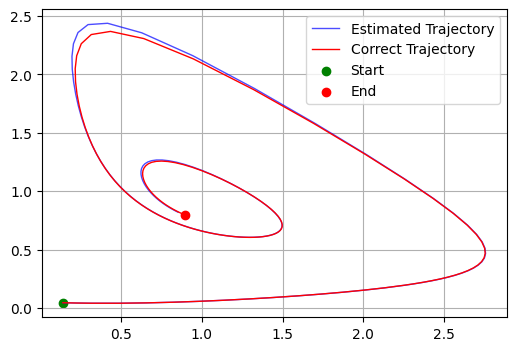

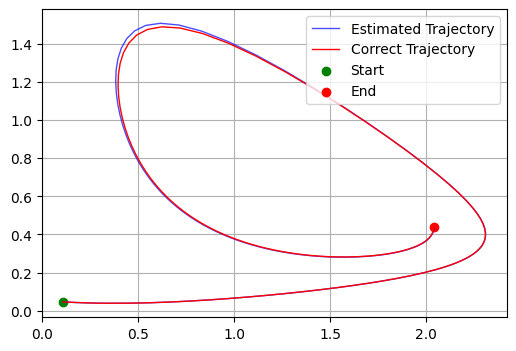

In [7]:
# Best Model, test on different parameter values:
init_point = [0.05, 0.05, 0.9]
rmse_0 = SINDy_data.evaluate_RMSE(model_04, ode, freq, n_sample, init_point, init_point)
print('rho=0.9, RMSE: ', rmse_0)
SINDy_data.evaluate_traj(model_04, ode, freq, n_sample, init_point, init_point, dim_x)

init_point = [0.05, 0.05, 0.6]
rmse_0 = SINDy_data.evaluate_RMSE(model_04, ode, freq, n_sample, init_point, init_point)
print('rho=0.6, RMSE: ', rmse_0)
SINDy_data.evaluate_traj(model_04, ode, freq, n_sample, init_point, init_point, dim_x)


##### Results:

$\rho \simeq 0.9$:  
(x1)' = 0.551 k + 0.727 k^2 + -0.842 x1 x2^2 + -0.314 x1 x2 k + -0.128 x2^2 k + 0.303 x2 k^2 + -0.401 k^3  
(x2)' = 0.102 x1 + -1.202 x2 + 0.480 x2 k + 0.984 x1 x2^2 + -0.266 x2 k^2  
SINDy does not identify the right ODEs, but approximate the model consistently (RMSE=0.0427). The estimated model also genralizes quite well to cases $\rho = 0.6, \rho = 0.4$ (RMSE~=0.1).

$\rho \simeq 0.6$:  
(x1)' = 0.362 k + 1.388 k^2 + -1.000 x1 x2^2 + -0.269 x1 k^2 + -0.561 k^3  
(x2)' = 0.100 x1 + -1.000 x2 + 1.000 x1 x2^2   
SINDy correctly identifies ODE (2), and approsimates ODE (1) accurately -> RMSE=0.01. The estimated model also genralizes quite well to cases $\rho = 0.9, \rho = 0.4$ (RMSE~=0.15).

$\rho \simeq 0.4$:  
(x1)' = -0.100 x1 + 1.000 k + -1.000 x1 x2^2  
(x2)' = 0.099 x1 + -0.984 x2 + -0.046 x2^2 + 1.004 x1 x2^2 + 0.030 x2^3  
SINDy correctly identifies ODE (1) and also ODE (2) estimate is very accurate -> RMSE=0.0003. The estimated model generalizes very well to cases $\rho = 0.94$ (RMSE=0.0306) and  $\rho = 0.6$ (RMSE=0.0064). 